In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device is : {device}')

Using device is : cuda


In [3]:
# Define data transformation
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split Validation set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Num training examples: {}".format(len(train_dataset)))
print("Num validation examples: {}".format(len(val_dataset)))
print("Num test examples: {}".format(len(test_dataset)))

100%|██████████| 170498071/170498071 [00:02<00:00, 82776182.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Num training examples: 40000
Num validation examples: 10000
Num test examples: 10000


torch.Size([64, 3, 32, 32])
torch.Size([64])


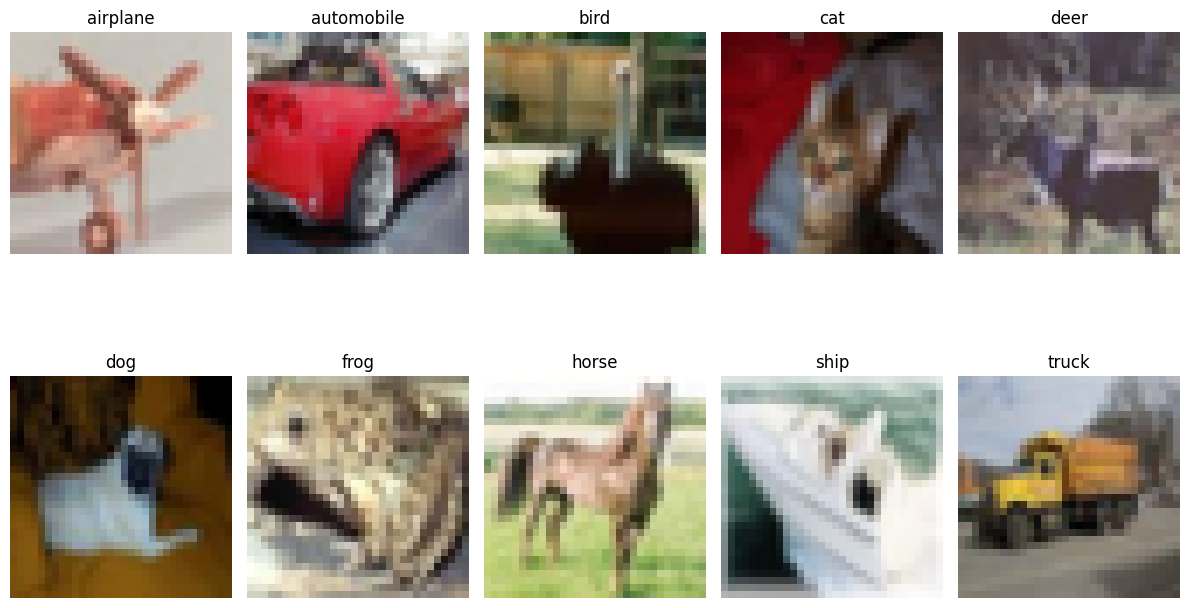

In [4]:
dataiter = iter(train_loader)
images,labels = next(dataiter)
print(images.shape)
print(labels.shape)

# CIFAR-10 class labels
classes = train_dataset.dataset.classes

# Create a dictionary to store one random image per class
class_images = {class_label: None for class_label in classes}

for i in range(len(labels)):
  label = classes[labels[i].item()]
  if class_images[label] is None:  # If we haven't collected an image for this class yet
    class_images[label] = (images[i], label)
# Break the loop if we have all classes
  if all(img is not None for img in class_images.values()):
    break

# Plot the images
plt.figure(figsize=(12, 8))
for i, (label, (img, _)) in enumerate(class_images.items()):
    plt.subplot(2, 5, i + 1)
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
def train(model, train_loader,val_loader, optimizer, criterion, num_epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    for epoch in range(num_epoch):
        running_loss = 0
        correct = 0
        total = 0
        model.train()

        # Training
        for i, (data, target) in enumerate(train_loader,0):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            _, pred = torch.max(output.data, 1)

            total += target.size(0)
            correct += (pred == target).sum().item()
            running_loss += loss.item()

        train_avg_loss = running_loss / (i+1)
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)
        train_loss.append(train_avg_loss)

        # Validation
        model.eval()
        val_running_loss, val_corrects, val_total = 0, 0, 0

        for j,(inputs, labels) in enumerate(val_loader,0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item()
            val_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)

        val_epoch_loss = val_running_loss / (j+1)
        val_epoch_acc = 100 * val_corrects / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epoch} - "
              f"Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}%, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.4f}%")


    return train_acc, train_loss, val_acc, val_loss



def test(model, train_loader, val_loader, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    dataLoader = [(train_loader, "Train"), (val_loader, "Validation"), (test_loader, "Test")]

    for data_loader, name in dataLoader:
        correct = 0
        total = 0
        val_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader, 0):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                _, pred = torch.max(output.data, 1)

                # Collect predictions and targets for confusion matrix
                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

                val_loss += loss.item()
                total += target.size(0)
                correct += (pred == target).sum().item()

        accuracy = 100 * correct / total
        avg_loss = val_loss / (i + 1)

        print(f"{name} Accuracy: {accuracy:.2f}%, {name} Loss: {avg_loss:.4f}")

        # Report confusion matrix for the test set
        if name == "Test":
            cm = confusion_matrix(all_targets, all_preds)
            #print(f"Confusion Matrix for {name} Set:")
            #print(cm)
            
            # Display confusion matrix as a heatmap
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f"Confusion Matrix for {name} Set")
            plt.show()



def plot_train(supetitle,train_loss,val_loss,train_acc,val_acc):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.suptitle(supetitle)
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [6]:
# Define the neural network
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(in_features=32*14*14, out_features=10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

# Create an instance of the neural network and move to device
baseline_model = BaselineModel().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

Baseline Model :
Epoch 1/20 - Train Loss: 1.7766, Train Accuracy: 37.9775%, Val Loss: 1.5604, Val Accuracy: 46.2100%
Epoch 2/20 - Train Loss: 1.4820, Train Accuracy: 48.2425%, Val Loss: 1.4020, Val Accuracy: 51.2000%
Epoch 3/20 - Train Loss: 1.3614, Train Accuracy: 52.6625%, Val Loss: 1.3204, Val Accuracy: 53.9100%
Epoch 4/20 - Train Loss: 1.2864, Train Accuracy: 55.2775%, Val Loss: 1.2748, Val Accuracy: 55.1200%
Epoch 5/20 - Train Loss: 1.2326, Train Accuracy: 57.3300%, Val Loss: 1.2224, Val Accuracy: 57.1700%
Epoch 6/20 - Train Loss: 1.1801, Train Accuracy: 59.0150%, Val Loss: 1.2024, Val Accuracy: 57.7900%
Epoch 7/20 - Train Loss: 1.1369, Train Accuracy: 60.6525%, Val Loss: 1.1670, Val Accuracy: 58.6600%
Epoch 8/20 - Train Loss: 1.0953, Train Accuracy: 62.3700%, Val Loss: 1.1272, Val Accuracy: 60.8000%
Epoch 9/20 - Train Loss: 1.0605, Train Accuracy: 63.7700%, Val Loss: 1.1021, Val Accuracy: 61.8200%
Epoch 10/20 - Train Loss: 1.0289, Train Accuracy: 64.5175%, Val Loss: 1.1045, Val A

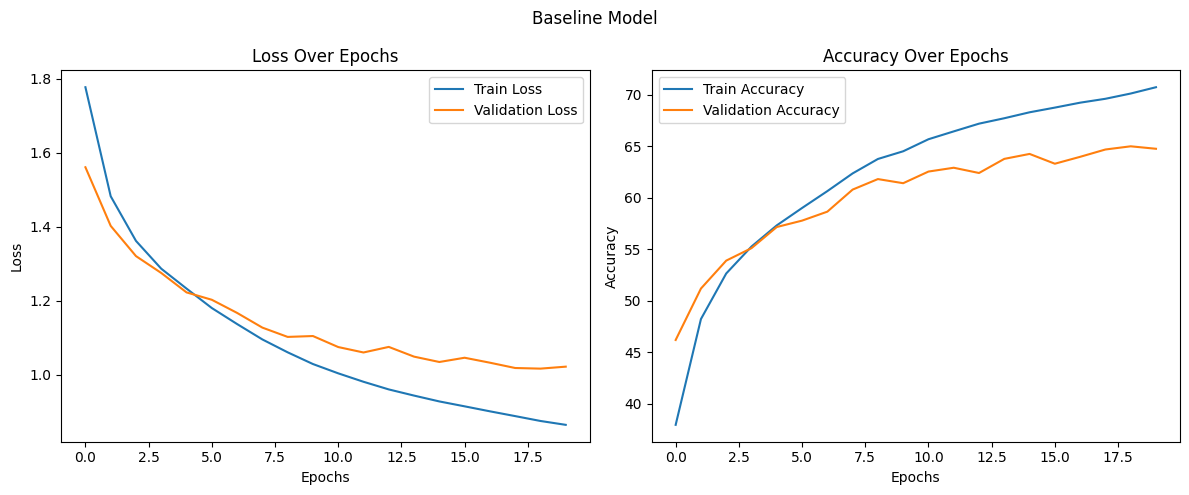

In [7]:
num_epochs = 20
print('Baseline Model :')
optimizer = optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.9)
train_acc, train_loss, val_acc, val_loss =train(baseline_model, train_loader, val_loader, optimizer, criterion, num_epochs)
plot_train('Baseline Model',train_loss,val_loss,train_acc,val_acc)

In [8]:
# Save the model checkpoint
torch.save(baseline_model.state_dict(), 'base_line_model.pth')
print('Model checkpoint saved!')

Model checkpoint saved!


In [9]:
class UpgradedModel(nn.Module):

  def __init__(self):
    super(UpgradedModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=128*8*8, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

# Create an instance of the neural network and move to device
model_v2 = UpgradedModel().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

Upgraded Model :
Epoch 1/20 - Train Loss: 2.1900, Train Accuracy: 20.8700%, Val Loss: 1.9698, Val Accuracy: 30.0500%
Epoch 2/20 - Train Loss: 1.8151, Train Accuracy: 35.8200%, Val Loss: 1.7086, Val Accuracy: 39.0300%
Epoch 3/20 - Train Loss: 1.6191, Train Accuracy: 42.4500%, Val Loss: 1.5162, Val Accuracy: 46.2400%
Epoch 4/20 - Train Loss: 1.4760, Train Accuracy: 47.4750%, Val Loss: 1.4044, Val Accuracy: 49.7700%
Epoch 5/20 - Train Loss: 1.3726, Train Accuracy: 51.1275%, Val Loss: 1.3424, Val Accuracy: 51.6700%
Epoch 6/20 - Train Loss: 1.2954, Train Accuracy: 54.1550%, Val Loss: 1.2580, Val Accuracy: 54.9900%
Epoch 7/20 - Train Loss: 1.2290, Train Accuracy: 56.5500%, Val Loss: 1.2132, Val Accuracy: 56.9500%
Epoch 8/20 - Train Loss: 1.1554, Train Accuracy: 59.2200%, Val Loss: 1.1589, Val Accuracy: 58.7400%
Epoch 9/20 - Train Loss: 1.0890, Train Accuracy: 61.7725%, Val Loss: 1.0907, Val Accuracy: 61.6400%
Epoch 10/20 - Train Loss: 1.0197, Train Accuracy: 64.1650%, Val Loss: 1.0437, Val A

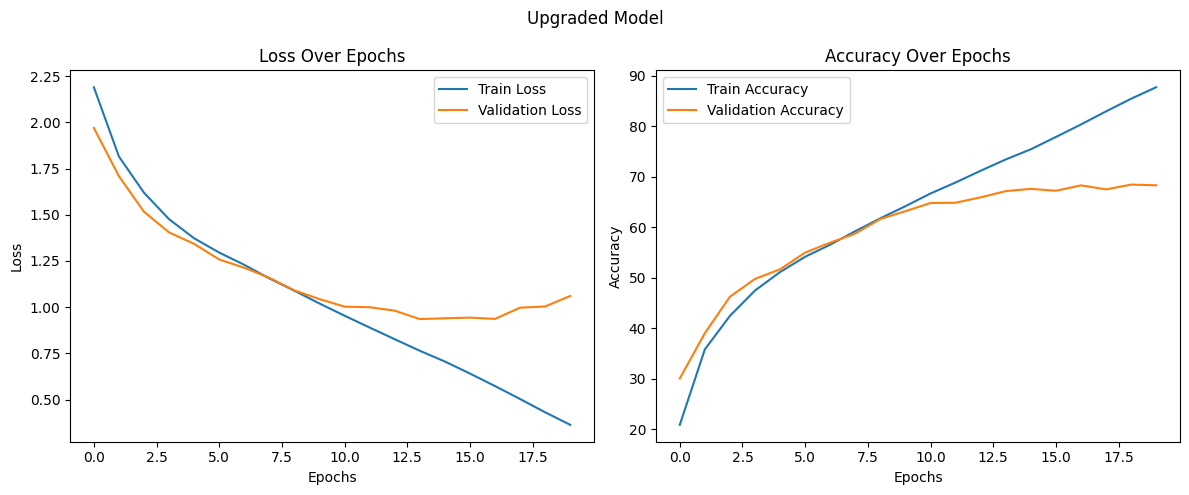

In [10]:
num_epochs = 20
print('Upgraded Model :')
optimizer = optim.SGD(model_v2.parameters(), lr=0.001, momentum=0.9)
train_acc, train_loss, val_acc, val_loss =train(model_v2, train_loader, val_loader, optimizer, criterion, num_epochs)
plot_train('Upgraded Model',train_loss,val_loss,train_acc,val_acc)

In [11]:
# Save the model checkpoint
torch.save(model_v2.state_dict(), 'model_v2.pth')
print('Model checkpoint saved!')

Model checkpoint saved!


In [12]:
class UpgradedModelWithBN(nn.Module):

  def __init__(self):
    super(UpgradedModelWithBN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
    self.bn3 = nn.BatchNorm2d(128)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=128*8*8, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

# Create an instance of the neural network and move to device
model_v3 = UpgradedModelWithBN().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

Upgraded Model with BN :
Epoch 1/20 - Train Loss: 1.3744, Train Accuracy: 50.9525%, Val Loss: 1.1083, Val Accuracy: 61.1600%
Epoch 2/20 - Train Loss: 0.9828, Train Accuracy: 65.3525%, Val Loss: 0.9615, Val Accuracy: 65.8400%
Epoch 3/20 - Train Loss: 0.8405, Train Accuracy: 70.7150%, Val Loss: 0.9078, Val Accuracy: 67.4300%
Epoch 4/20 - Train Loss: 0.7390, Train Accuracy: 74.3000%, Val Loss: 0.8429, Val Accuracy: 71.0600%
Epoch 5/20 - Train Loss: 0.6441, Train Accuracy: 77.7850%, Val Loss: 0.8210, Val Accuracy: 71.3300%
Epoch 6/20 - Train Loss: 0.5729, Train Accuracy: 80.4050%, Val Loss: 0.7596, Val Accuracy: 73.2600%
Epoch 7/20 - Train Loss: 0.4935, Train Accuracy: 83.2650%, Val Loss: 0.7425, Val Accuracy: 74.4800%
Epoch 8/20 - Train Loss: 0.4275, Train Accuracy: 85.6400%, Val Loss: 0.7381, Val Accuracy: 74.9200%
Epoch 9/20 - Train Loss: 0.3598, Train Accuracy: 88.3150%, Val Loss: 0.7950, Val Accuracy: 73.8000%
Epoch 10/20 - Train Loss: 0.3047, Train Accuracy: 90.2700%, Val Loss: 0.816

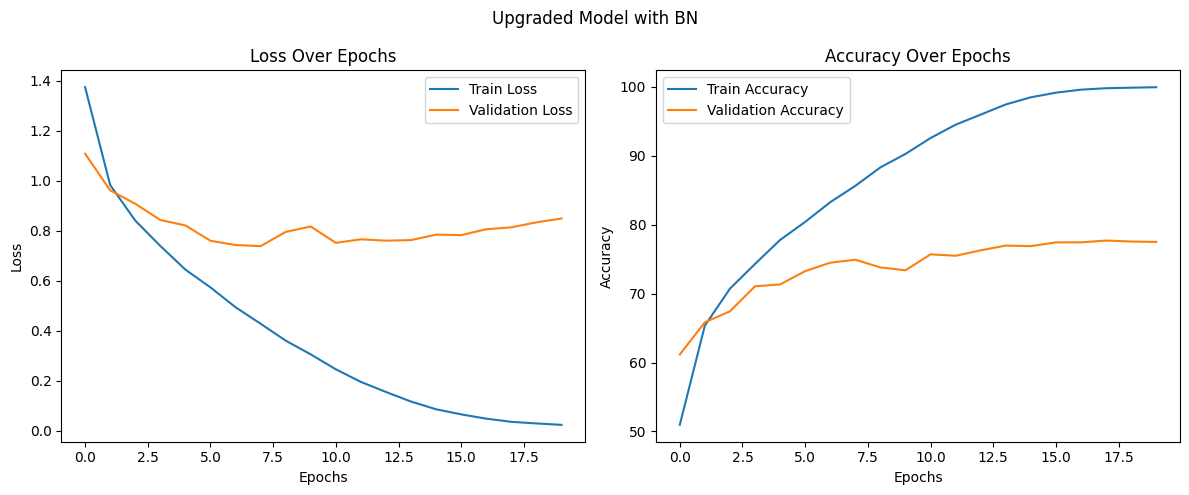

In [13]:
num_epochs = 20
print('Upgraded Model with BN :')
optimizer = optim.SGD(model_v3.parameters(), lr=0.001, momentum=0.9)
train_acc, train_loss, val_acc, val_loss =train(model_v3, train_loader, val_loader, optimizer, criterion, num_epochs)
plot_train('Upgraded Model with BN',train_loss,val_loss,train_acc,val_acc)

In [14]:
# Save the model checkpoint
torch.save(model_v3.state_dict(), 'model_v3.pth')
print('Model checkpoint saved!')

Model checkpoint saved!


Using Batch Norm increases model accuracy.

In [15]:
class UpgradedModelWithBNAndDropout(nn.Module):

  def __init__(self):
    super(UpgradedModelWithBNAndDropout, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
    self.bn2 = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
    self.bn3 = nn.BatchNorm2d(128)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=128*8*8, out_features=512)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(in_features=512, out_features=10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

# Create an instance of the neural network and move to device
model_v4 = UpgradedModelWithBNAndDropout().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

Upgraded Model with BN and Dropout :
Epoch 1/20 - Train Loss: 1.4992, Train Accuracy: 45.6900%, Val Loss: 1.1633, Val Accuracy: 58.4800%
Epoch 2/20 - Train Loss: 1.1369, Train Accuracy: 59.4250%, Val Loss: 0.9928, Val Accuracy: 64.6400%
Epoch 3/20 - Train Loss: 0.9782, Train Accuracy: 65.6350%, Val Loss: 0.9384, Val Accuracy: 66.5600%
Epoch 4/20 - Train Loss: 0.8881, Train Accuracy: 68.7550%, Val Loss: 0.8728, Val Accuracy: 68.9900%
Epoch 5/20 - Train Loss: 0.8069, Train Accuracy: 71.7175%, Val Loss: 0.8425, Val Accuracy: 70.6300%
Epoch 6/20 - Train Loss: 0.7512, Train Accuracy: 73.4675%, Val Loss: 0.7845, Val Accuracy: 72.4900%
Epoch 7/20 - Train Loss: 0.6965, Train Accuracy: 75.6800%, Val Loss: 0.7261, Val Accuracy: 74.5500%
Epoch 8/20 - Train Loss: 0.6480, Train Accuracy: 77.1825%, Val Loss: 0.7612, Val Accuracy: 73.5400%
Epoch 9/20 - Train Loss: 0.5951, Train Accuracy: 79.3500%, Val Loss: 0.6948, Val Accuracy: 75.8700%
Epoch 10/20 - Train Loss: 0.5553, Train Accuracy: 80.6225%, Val

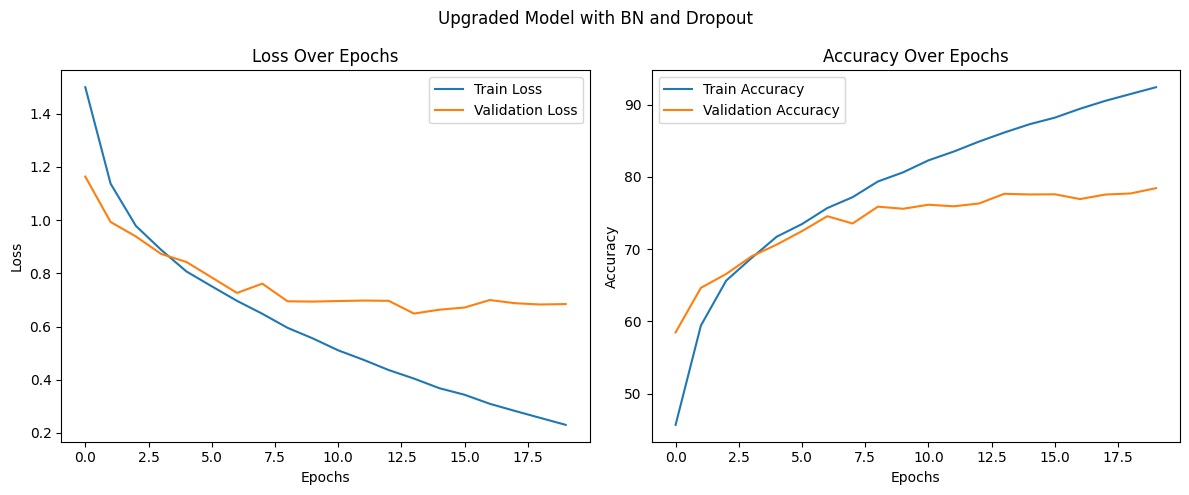

In [16]:
num_epochs = 20
print('Upgraded Model with BN and Dropout :')
optimizer = optim.SGD(model_v4.parameters(), lr=0.001, momentum=0.9)
train_acc, train_loss, val_acc, val_loss =train(model_v4, train_loader, val_loader, optimizer, criterion, num_epochs)
plot_train('Upgraded Model with BN and Dropout',train_loss,val_loss,train_acc,val_acc)

In [17]:
# Save the model checkpoint
torch.save(model_v4.state_dict(), 'model_v4.pth')
print('Model checkpoint saved!')

Model checkpoint saved!


Dropout reduces the overfit, as we can observe, training accuracy has decreased but validation accuracy has increased. We expect to get a 1.5-2% better performance while using dropout, and we get our 1% here.

In [18]:
# Load the models checkpoint
loaded_v1 = BaselineModel().to(device)
loaded_v1.load_state_dict(torch.load('base_line_model.pth'))

loaded_v2 = UpgradedModel().to(device)
loaded_v2.load_state_dict(torch.load('model_v2.pth'))

loaded_v3 = UpgradedModelWithBN().to(device)
loaded_v3.load_state_dict(torch.load('model_v3.pth'))

loaded_v4 = UpgradedModelWithBNAndDropout().to(device)
loaded_v4.load_state_dict(torch.load('model_v4.pth'))

/tmp/ipykernel_23/1573114164.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_v1.load_state_dict(torch.load('base_line_model.pth'))
/tmp/ipykernel_23/1573114164.py

<All keys matched successfully>

Baseline Model :
Train Accuracy: 71.44%, Train Loss: 0.8362
Validation Accuracy: 64.76%, Validation Loss: 1.0218
Test Accuracy: 64.61%, Test Loss: 1.0326


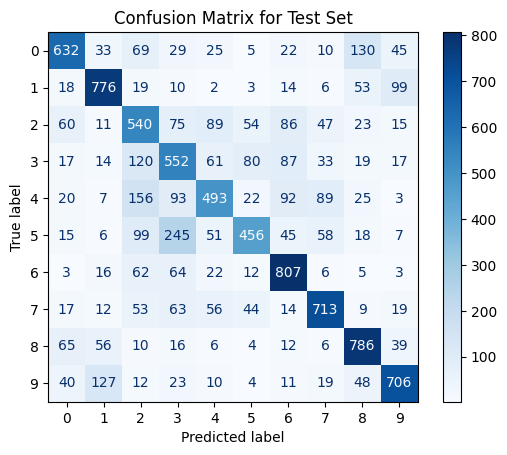

Upgraded Model :
Train Accuracy: 90.94%, Train Loss: 0.2857
Validation Accuracy: 68.31%, Validation Loss: 1.0609
Test Accuracy: 67.49%, Test Loss: 1.0971


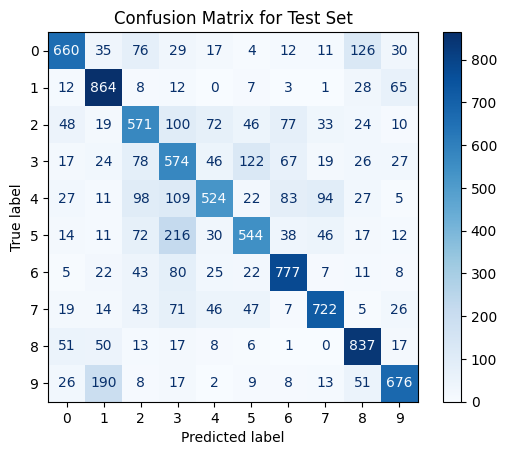

Upgraded Model with BN :
Train Accuracy: 99.99%, Train Loss: 0.0159
Validation Accuracy: 77.50%, Validation Loss: 0.8487
Test Accuracy: 77.25%, Test Loss: 0.8593


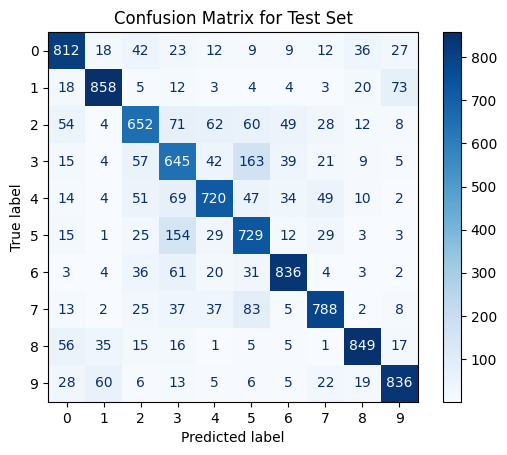

Upgraded Model with BN and Dropout :
Train Accuracy: 97.38%, Train Loss: 0.1230
Validation Accuracy: 78.43%, Validation Loss: 0.6844
Test Accuracy: 77.63%, Test Loss: 0.7038


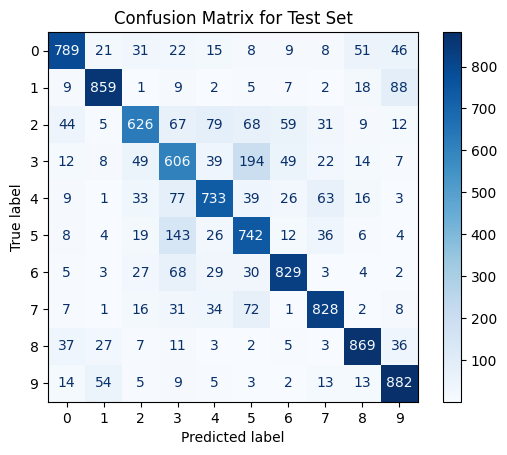

In [19]:
# Print accuracy and confusion matrix
print('Baseline Model :')
test(loaded_v1, train_loader, val_loader, test_loader, criterion)

print('Upgraded Model :')
test(loaded_v2, train_loader, val_loader, test_loader, criterion)

print('Upgraded Model with BN :')
test(loaded_v3, train_loader, val_loader, test_loader, criterion)

print('Upgraded Model with BN and Dropout :')
test(loaded_v4, train_loader, val_loader, test_loader, criterion)
